 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Dec/2023 21:24:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Dec/2023 21:24:33] "GET /docs/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Dec/2023 21:24:33] "GET /flasgger_static/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [02/Dec/2023 21:24:33] "GET /flasgger_static/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Dec/2023 21:24:33] "GET /flasgger_static/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Dec/2023 21:24:33] "GET /flasgger_static/lib/jquery.min.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Dec/2023 21:24:33] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [02/Dec/2023 21:25:07] "POST /text-processing-file HTTP/1.1" 200 -
127.0.0.1 - - [02/Dec/2023 21:25:35] "POST /text_processing HTTP/1.1" 200 -


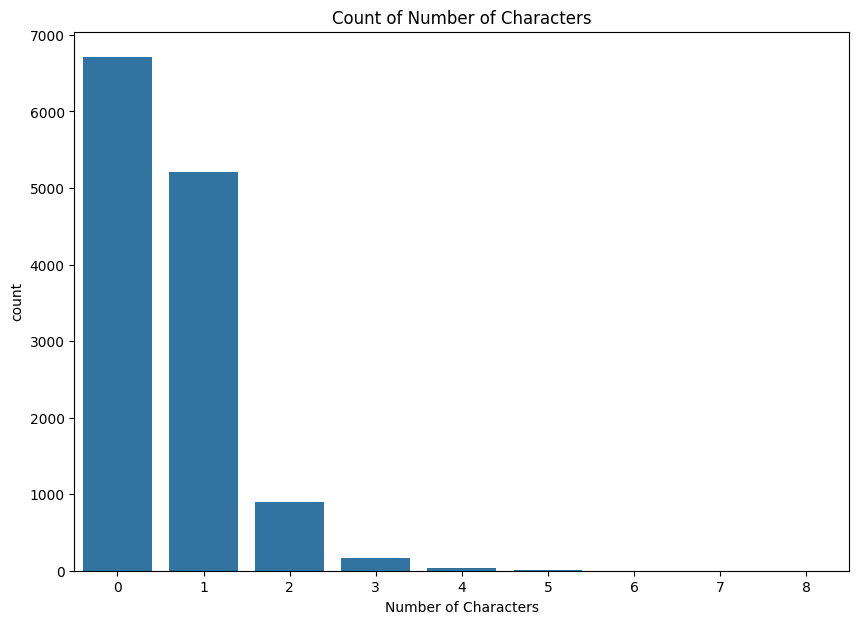

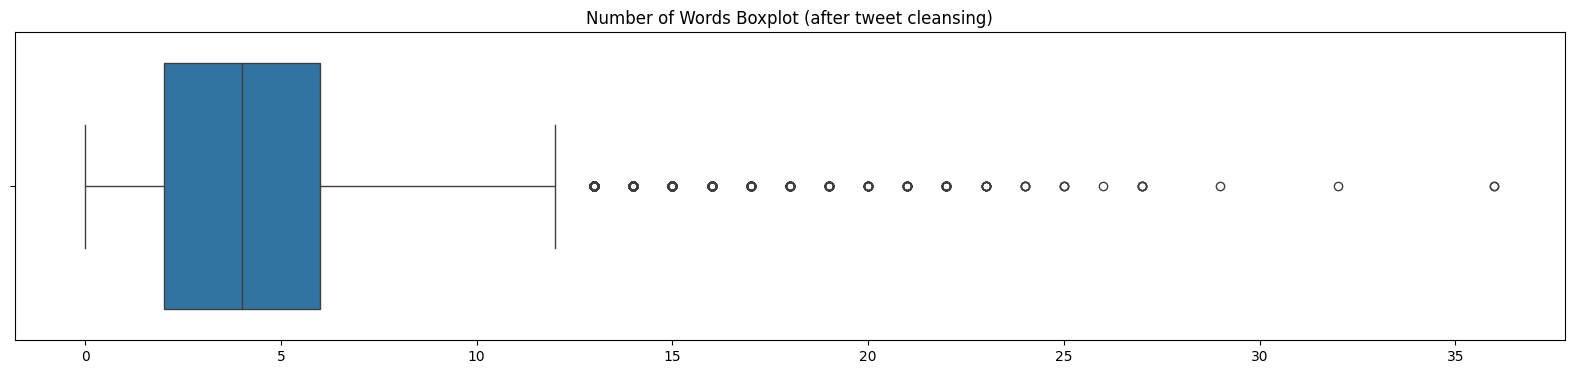

In [4]:
# uji coba 2 des part 4
# berhasil text_processing, text_processing_file, sqlite, visualisation (abs word dan alay word)

# IMPORT PACKAGE
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, jsonify, request
from flasgger import Swagger, LazyJSONEncoder, swag_from

# RUNNING CODE FLASK
app = Flask(__name__)

# Membaca file csv daftar kata baku dan tidak baku
df_kamusalay = pd.read_csv('C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/Asset Challenge/new_kamusalay.csv', encoding='latin-1', header=None)
df_kamusalay.columns = ["tidak_baku", "baku"]
kamus_alay = dict(zip(df_kamusalay["tidak_baku"], df_kamusalay["baku"]))

# Membaca file csv kata kasar
df_abusive = pd.read_csv('C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/Asset Challenge/abusive.csv')

# Mengambil daftar kata kasar
kata_abusive = df_abusive['ABUSIVE'].tolist()

app.json_encoder = LazyJSONEncoder
swagger_template = {
    "info": {
        "title": "API Documentation for Data Processing and Modeling",
        "version": "1.0.0",
        "description": "Dokumentasi API untuk Data Processing dan Modeling",
    },
    "host": "127.0.0.1:5000"
}

swagger_config = {
    "headers": [],
    "specs": [
        {
            "endpoint": 'docs',
            "route": '/docs.json',
        }
    ],
    "static_url_path": "/flasgger_static",
    "swagger_ui": True,
    "specs_route": "/docs/"
}

swagger = Swagger(app, template=swagger_template, config=swagger_config)

# MENJALANKAN FILE YML hello_world, text, dan text_clean
@swag_from('C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/docs/hello_world.yml', methods=['GET'])
@app.route('/', methods=['GET'])
def hello_world():
    json_response = {
        'status_code': 200,
        'description': "Menyapa Hello World",
        'data': "Hello World",
    }
    return jsonify(json_response)

@swag_from('C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/docs/text.yml', methods=['GET'])
@app.route('/text', methods=['GET'])
def text():
    json_response = {
        'status_code': 200,
        'description': "Original Teks",
        'data': "Text",
    }
    return jsonify(json_response)

@swag_from('C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/docs/text_clean.yml', methods=['GET'])
@app.route('/text_clean', methods=['GET'])
def text_clean():
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah dibersihkan",
        'data': "Text Clean",
    }
    return jsonify(json_response)

# MELAKUKAN CLEANSING TEXT YANG DIINPUT
@swag_from('C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/docs/text_processing.yml', methods=['POST'])
@app.route('/text_processing', methods=['POST'])
def text_processing():
    try:
        data = request.form.get('text')
        # MENGHITUNG JUMLAH KATA ABUSIVE
        def count_abusive_text(text):
            cleaned_text = re.sub(r'\\x[a-f0-9]{2}', '', text)
            cleaned_text = re.sub(r'[^a-zA-Z0-9 ]', '', cleaned_text).lower()
            matched_count = sum(1 for word in cleaned_text.split() if word in df_abusive['ABUSIVE'].values)
            return matched_count
        # MENGHITUNG JUMLAH KATA TIDAK BAKU
        def count_alay_text(text):
            cleaned_text = re.sub(r'\\x[a-f0-9]{2}', '', text)
            cleaned_text = re.sub(r'[^a-zA-Z0-9 ]', '', cleaned_text).lower()
            alay_count = sum(1 for word in cleaned_text.split() if word in kamus_alay)
            return alay_count
        # MEMPROSES CLEANSING DATA
        def text_cleansing_text(text):
            cleaned_text = re.sub(r'\\x[a-f0-9]{2}', '', text)
            cleaned_text = re.sub(r'[^a-zA-Z0-9 ]', '', cleaned_text).lower()
            kata_bersih = [kamus_alay.get(word, word) for word in cleaned_text.split()]
            kata_bersih = [word for word in kata_bersih if word not in df_abusive['ABUSIVE'].values]
            return ' '.join(kata_bersih)
        # MELAKUKAN POST DATAFRAME
        post_df = pd.DataFrame({'text': [data]})
        post_df['estimated_no_abs_words_text'] = post_df['text'].apply(count_abusive_text)
        post_df['estimated_no_alay_words_text'] = post_df['text'].apply(count_alay_text)
        #MENAMPILKAN HASIL TEXT CLEANSING PROCESSING
        result = {
            'status_code': 200,
            'message': 'Successful response',
            'data': {
                'cleaned_texts': post_df['text'].apply(text_cleansing_text).tolist(),
                'estimated_no_abs_words_text': post_df['estimated_no_abs_words_text'].tolist(),
                'estimated_no_alay_words_text': post_df['estimated_no_alay_words_text'].tolist()
            }
        }

        return jsonify(result)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return jsonify({'status_code': 500, 'error': 'Internal Server Error'}), 500
    
# MELAKUKAN CLEANSING TEXT VIA FILE YANG DIINPUT
@swag_from("C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/docs/text_processing_file.yml", methods=['POST'])
@app.route('/text-processing-file', methods=['POST'])
def text_processing_file():
    try:
        # Menggunakan request.files['file'] untuk mendapatkan file yang diunggah
        file = request.files['file']

        # IMPOR FILE OBJECT KE DALAM PANDAS DATAFRAME
        post_df = pd.read_csv(file, encoding='latin-1')

        # Menjaga DataFrame, tidak mengubahnya menjadi Series
        post_df = post_df[['Tweet']]

        # MENGHAPUS/MENGHILANGKAN DATA GANDA
        post_df.drop_duplicates(inplace=True)

        # MEMBUAT KOLOM BARU YANG BERISI JUMLAH KARAKTER
        post_df['no_char'] = post_df['Tweet'].apply(len)

        # MEMBUAT KOLOM BARU YANG BERISI JUMLAH KATA
        post_df['no_words'] = post_df['Tweet'].apply(lambda x: len(x.split()))
    
        # MENGHITUNG JUMLAH KATA YANG MENGANDUNG KATA ABUSIVE
        def count_abusive(tweet):
            word_tweet = tweet.split()
            cleaned_tweet = re.sub(r'\\x[a-f0-9]{2}', '', ' '.join(word_tweet))
            cleaned_tweet = re.sub(r'[^a-zA-Z0-9 ]', '', cleaned_tweet).lower()
            matched_count = 0
            for i in range(len(df_abusive)):
                word = df_abusive['ABUSIVE'].iloc[i].lower()
                if word in cleaned_tweet.split():
                    matched_count += 1
            return matched_count

        post_df['estimated_no_abs_words'] = post_df['Tweet'].apply(count_abusive)
    
        # MENGHITUNG JUMLAH KATA YANG MENGANDUNG KATA TIDAK BAKU
        def count_alay(tweet):
            word_tweet = tweet.split()
            cleaned_tweet = re.sub(r'\\x[a-f0-9]{2}', '', ' '.join(word_tweet))
            cleaned_tweet = re.sub(r'[^a-zA-Z0-9 ]', '', cleaned_tweet).lower()
            alay_count = sum(1 for word in cleaned_tweet.split() if word in kamus_alay)
            return alay_count
    
        post_df['estimated_no_alay_words'] = post_df['Tweet'].apply(count_alay)


        # MELAKUKAN CLEANSING DATA
        def tweet_cleansing(x):
            tweet = x
            word_tweet = tweet.split()
            cleaned_tweet = re.sub(r'\\x[a-f0-9]{2}', '', ' '.join(word_tweet))
            # untuk membersihkan non alphanumeric
            cleaned_tweet = re.sub(r'[^a-zA-Z0-9 ]', '', cleaned_tweet).lower()
            kata_bersih = [kamus_alay.get(word, word) for word in cleaned_tweet.split()]
            kata_bersih = [word for word in kata_bersih if word not in kata_abusive]
            return ' '.join(kata_bersih)
    
        # Koneksi ke database SQLite untuk menyimpan hasil cleansing ke dalam tabel 'history'
        connection = sqlite3.connect('cleansingfilehistory.db')
        cursor = connection.cursor()

        # Membuat tabel 'history' jika belum ada
        cursor.execute("DROP TABLE IF EXISTS history")
        connection.commit()
        cursor.execute("CREATE TABLE IF NOT EXISTS history (tweet TEXT, no_char INTEGER, no_words INTEGER, cleaned_tweets TEXT, estimated_no_abs_words INTEGER, estimated_no_alay_words INTEGER)")

        # Menyimpan hasil cleansing ke dalam tabel 'history'
        for i in range(len(post_df)):
            tweet = post_df['Tweet'].iloc[i]
            no_char = int(post_df['no_char'].iloc[i])
            no_words = int(post_df['no_words'].iloc[i])
            cleaned_tweet = tweet_cleansing(tweet)
            estimated_no_abs_words = int(post_df['estimated_no_abs_words'].iloc[i])
            estimated_no_alay_words = int(post_df['estimated_no_alay_words'].iloc[i])

            # Query SQL untuk insert data
            q_insertion = "INSERT INTO history (tweet, no_char, no_words, cleaned_tweets, estimated_no_abs_words, estimated_no_alay_words) VALUES (?, ?, ?, ?, ?, ?)"
            cursor.execute(q_insertion, (tweet, no_char, no_words, cleaned_tweet, estimated_no_abs_words, estimated_no_alay_words))

        # Commit perubahan ke database
        connection.commit()

        # Menutup kursor dan koneksi
        cursor.close()
        connection.close()

        # VISUALISASI DATA DENGAN MENAMPILKAN JUMLAH KATA ABUSIVE DAN KATA TIDAK BAKU YANG TERKANDUNG DALAM FILE
        plt.figure(figsize=(10, 7))
        countplot = sns.countplot(data=post_df, x="estimated_no_abs_words")  
        plt.title('Count of Number of Characters')
        plt.xlabel('Number of Characters')
        plt.savefig('C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/character_countplot.jpeg')  

        plt.figure(figsize=(20, 4))
        boxplot = sns.boxplot(data=post_df, x="estimated_no_alay_words")  

        plt.title('Number of Words Boxplot (after tweet cleansing)')
        plt.xlabel('')
        plt.savefig('C:/Users/ROG/Documents/Data-20231031T003049Z-001/project-hate-speech/new_boxplot.jpeg')  

        #MENAMPILKAN HASIL TEXT CLEANSING PROCESSING
        result = {
            'status_code': 200,
            'message': 'Successful response',
            'data': {
                'no_char': post_df['no_char'].tolist(),
                'no_words': post_df['no_words'].tolist(),
                'cleaned_tweets': post_df['Tweet'].apply(tweet_cleansing).tolist(),
                'estimated_no_abs_words': post_df['estimated_no_abs_words'].tolist(),
                'estimated_no_alay_words': post_df['estimated_no_alay_words'].tolist()
            }
        }

    except Exception as e:
        result = {
            'status_code': 500,
            'message': f'Internal Server Error: {str(e)}',
            'data': None
        }

    return jsonify(result)

if __name__ == '__main__':
    app.run()